# NLP for Extraction of Phenotypes for Inherited Retinal Disease of EHR - Preprocessing

Dataset: randomly sample 500 discharge summaries (DS) from MIMIC-III. <br>
Discription of the dataset: https://mimic.mit.edu/docs/iii/tables/ <br>
Contents: <a id="0"></a>
......TO BE FILLED IN LATER

## Importing additional Python libraries<a class="anchor" id="1"></a>
<mark>[Return Contents](#0)

In [5]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalMaxPool1D, Conv1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support

In [6]:
import torch
print(torch.__version__)
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

1.9.0+cu111
2.3.0
2.4.3


In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [20]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

## Importing Dataset and preprocessing <a class="anchor" id="2"></a>
<mark>[Return Contents](#0)

In [8]:
path = ('MIMIC-III discharge summaries 1073 rare disease annotations.xlsx')
xl = pd.ExcelFile(path)
df = xl.parse('Sheet1')
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT_whole_doc,document structure,TEXT_in_doc_structure,mention,UMLS with desc,ORDO with desc,gold mention-to-UMLS label,gold UMLS-to-ORDO label,gold mention-to-ORDO label
0,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,interpretation,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,MR,C0311284 Lipoid dermatoarthritis,Orphanet_139436 Multicentric reticulohistiocy...,0,1,0
1,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0
2,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0
3,545,6787,157546,Discharge summary,Report,Admission Date: [**2175-1-28**] ...,Hospital_course,Brief Hospital Course:\nNeuro-patient is in a ...,endo,C0014175 Endo,Orphanet_137820 Extrapelvic endometriosis,0,0,0
4,718,77484,176395,Discharge summary,Report,Admission Date: [**2164-5-3**] D...,Discharge_Medications,Discharge Medications:\n1. Aspirin 325 mg Tabl...,ml iv,C0238286 Sialolipidoses,Orphanet_578 Mucolipidosis type IV,0,1,0


In [9]:
df.shape

(1073, 14)

In [10]:
print(df.columns.tolist()) # column names

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION', 'TEXT_whole_doc', 'document structure', 'TEXT_in_doc_structure', 'mention', 'UMLS with desc', 'ORDO with desc', 'gold mention-to-UMLS label', 'gold UMLS-to-ORDO label', 'gold mention-to-ORDO label']


In [11]:
df.dtypes

ROW_ID                         int64
SUBJECT_ID                     int64
HADM_ID                        int64
CATEGORY                      object
DESCRIPTION                   object
TEXT_whole_doc                object
document structure            object
TEXT_in_doc_structure         object
mention                       object
UMLS with desc                object
ORDO with desc                object
gold mention-to-UMLS label     int64
gold UMLS-to-ORDO label        int64
gold mention-to-ORDO label     int64
dtype: object

In [12]:
df['document structure'].value_counts()

Hospital_course                         359
History_of_Past_Illness                 171
History_of_Present_Illness              139
pertinent_results                        64
Discharge_Diagnosis                      58
Discharge_Medications                    54
Admission_Medications                    49
basic                                    36
Hospital_Discharge_Physical              30
Review_of_Systems                        18
Chief_Complaint_and_Reason_for_Visit     15
facility                                 14
Social_History                           11
Procedures                                9
Hospital_Discharge_Studies                9
Hospital_Discharge_Instructions           8
interpretation                            7
admission_studies                         5
impression                                5
Problem                                   4
Immunizations                             2
Nutrition                                 2
Vital_Signs                     

### Data cleaning <a class="anchor" id="2_1"></a>

In [13]:
df.isnull().any()

ROW_ID                        False
SUBJECT_ID                    False
HADM_ID                       False
CATEGORY                      False
DESCRIPTION                   False
TEXT_whole_doc                False
document structure            False
TEXT_in_doc_structure         False
mention                       False
UMLS with desc                False
ORDO with desc                False
gold mention-to-UMLS label    False
gold UMLS-to-ORDO label       False
gold mention-to-ORDO label    False
dtype: bool

Class lable : `gold mention-to-UMLS label`: Check whether the matching is correct from the mention to the UMLS concept, 1 if correct, 0 if not.

In [14]:
df['gold mention-to-UMLS label'].value_counts() # 1 incorrect data for 'gold mention-to-UMLS label'

 0    743
 1    329
-1      1
Name: gold mention-to-UMLS label, dtype: int64

In [15]:
df.drop(df[df['gold mention-to-UMLS label'] == -1].index, inplace=True) # delete unexpected data

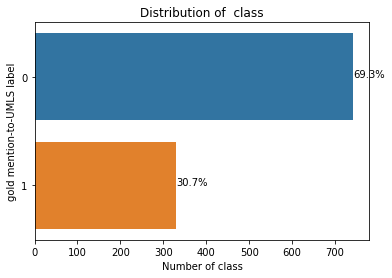

In [16]:
ax = sns.countplot(y="gold mention-to-UMLS label", data=df)
plt.title('Distribution of  class')
plt.xlabel('Number of class')
total = len(df['gold mention-to-UMLS label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
# plt.savefig('class_label')
plt.show()

### Identify location of mentions<a class="anchor" id="2_2"></a>

Extract mentions based on location of `*****` in column `TEXT_in_doc_structure`.

In [11]:
sub = '*****'
start = df.TEXT_in_doc_structure.str.find(sub) # Calling .find and passing '*****'
start.name = 'start' # naming the series so we can call it later
start = start + 5
# start.head(7) # displaying the results
df['start'] = start
# df.head(7)
end = df.TEXT_in_doc_structure.str.rfind(sub) # Calling .rfind and passing '*****'
end.name = 'end' # naming the series so we can call it later
# end.head(7) # displaying the results
df['end'] = end
# df.head(7)

In [12]:
df['mention_new'] = df.apply(lambda x: x['TEXT_in_doc_structure'][x['start']:x['end']], axis=1)
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT_whole_doc,document structure,TEXT_in_doc_structure,mention,UMLS with desc,ORDO with desc,gold mention-to-UMLS label,gold UMLS-to-ORDO label,gold mention-to-ORDO label,start,end,mention_new
0,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,interpretation,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,MR,C0311284 Lipoid dermatoarthritis,Orphanet_139436 Multicentric reticulohistiocy...,0,1,0,4452,4454,MR
1,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,3716,3718,HD
2,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,4133,4135,HD
3,545,6787,157546,Discharge summary,Report,Admission Date: [**2175-1-28**] ...,Hospital_course,Brief Hospital Course:\nNeuro-patient is in a ...,endo,C0014175 Endo,Orphanet_137820 Extrapelvic endometriosis,0,0,0,2287,2291,Endo
4,718,77484,176395,Discharge summary,Report,Admission Date: [**2164-5-3**] D...,Discharge_Medications,Discharge Medications:\n1. Aspirin 325 mg Tabl...,ml iv,C0238286 Sialolipidoses,Orphanet_578 Mucolipidosis type IV,0,1,0,1166,1171,mL IV


Delete `*****` in column `TEXT_in_doc_structure`.

In [13]:
df['TEXT_in_doc_structure_new'] = df['TEXT_in_doc_structure'].str.replace('\*\*\*\*\*','',regex=True)

In [14]:
# Check whether '*****' has been deleted properly in the new column 'TEXT_in_doc_structure_new'
df_TEXT_in_doc_structure = df[['TEXT_in_doc_structure']]
df_TEXT_in_doc_structure_new = df[['TEXT_in_doc_structure_new']]
df_TEXT_in_doc_structure['count1'] = df_TEXT_in_doc_structure.astype(str).apply(lambda x: x.str.len()).sum(1)
# df_TEXT_in_doc_structure.head()
df_TEXT_in_doc_structure_new['count2'] = df_TEXT_in_doc_structure_new.astype(str).apply(lambda x: x.str.len()).sum(1)
# df_TEXT_in_doc_structure_new.head()
# df.to_csv('df.csv', index=False, header=True) # save dataframe to csv

/home/yilin/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [15]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT_whole_doc,document structure,TEXT_in_doc_structure,mention,UMLS with desc,ORDO with desc,gold mention-to-UMLS label,gold UMLS-to-ORDO label,gold mention-to-ORDO label,start,end,mention_new,TEXT_in_doc_structure_new
0,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,interpretation,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,MR,C0311284 Lipoid dermatoarthritis,Orphanet_139436 Multicentric reticulohistiocy...,0,1,0,4452,4454,MR,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...
1,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,3716,3718,HD,Brief Hospital Course:\n80yo woman with severe...
2,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,4133,4135,HD,Brief Hospital Course:\n80yo woman with severe...
3,545,6787,157546,Discharge summary,Report,Admission Date: [**2175-1-28**] ...,Hospital_course,Brief Hospital Course:\nNeuro-patient is in a ...,endo,C0014175 Endo,Orphanet_137820 Extrapelvic endometriosis,0,0,0,2287,2291,Endo,Brief Hospital Course:\nNeuro-patient is in a ...
4,718,77484,176395,Discharge summary,Report,Admission Date: [**2164-5-3**] D...,Discharge_Medications,Discharge Medications:\n1. Aspirin 325 mg Tabl...,ml iv,C0238286 Sialolipidoses,Orphanet_578 Mucolipidosis type IV,0,1,0,1166,1171,mL IV,Discharge Medications:\n1. Aspirin 325 mg Tabl...


## Tokenize and lemmatize texts<a class="anchor" id="3"></a>
<mark>[Return Contents](#0)
### Tokenization<a class="anchor" id="3_1"></a>

In [16]:
print (list(df))

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION', 'TEXT_whole_doc', 'document structure', 'TEXT_in_doc_structure', 'mention', 'UMLS with desc', 'ORDO with desc', 'gold mention-to-UMLS label', 'gold UMLS-to-ORDO label', 'gold mention-to-ORDO label', 'start', 'end', 'mention_new', 'TEXT_in_doc_structure_new']


In [17]:
print(df['mention_new'].iloc[0])

MR


In [18]:
df['mention_new2'] = df['mention_new'].str.lower() # convert to lower case
print(df['mention_new2'].iloc[0])

mr


In [19]:
print (nltk.word_tokenize(df['mention_new2'].iloc[0]))

['mr']


We will now apply the word_tokenize to all records, making a new column in our df_annotation DataFrame. Each entry will be a list of words. Here we will also strip out non alphanumeric words/characters (such as numbers and punctuation) using `.isalpha` (apply `.isalnum` if you wanted to keep in numbers as well).

In [20]:
def identify_tokens(row):
    text = row['mention_new2']
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['mention_new2'] = df.apply(identify_tokens, axis=1)

In [21]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT_whole_doc,document structure,TEXT_in_doc_structure,mention,UMLS with desc,ORDO with desc,gold mention-to-UMLS label,gold UMLS-to-ORDO label,gold mention-to-ORDO label,start,end,mention_new,TEXT_in_doc_structure_new,mention_new2
0,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,interpretation,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,MR,C0311284 Lipoid dermatoarthritis,Orphanet_139436 Multicentric reticulohistiocy...,0,1,0,4452,4454,MR,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,[mr]
1,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,3716,3718,HD,Brief Hospital Course:\n80yo woman with severe...,[hd]
2,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,4133,4135,HD,Brief Hospital Course:\n80yo woman with severe...,[hd]
3,545,6787,157546,Discharge summary,Report,Admission Date: [**2175-1-28**] ...,Hospital_course,Brief Hospital Course:\nNeuro-patient is in a ...,endo,C0014175 Endo,Orphanet_137820 Extrapelvic endometriosis,0,0,0,2287,2291,Endo,Brief Hospital Course:\nNeuro-patient is in a ...,[endo]
4,718,77484,176395,Discharge summary,Report,Admission Date: [**2164-5-3**] D...,Discharge_Medications,Discharge Medications:\n1. Aspirin 325 mg Tabl...,ml iv,C0238286 Sialolipidoses,Orphanet_578 Mucolipidosis type IV,0,1,0,1166,1171,mL IV,Discharge Medications:\n1. Aspirin 325 mg Tabl...,"[ml, iv]"


### Stemming<a class="anchor" id="3_2"></a>
Trying to shorten a word with simple regex rules

In [22]:
stemming = PorterStemmer()
my_list = df['mention_new2'].iloc[0]
# Using a Python list comprehension method to apply to all words in my_list
print ([stemming.stem(word) for word in my_list])

['mr']


In [23]:
def stem_list(row):
    my_list = row['mention_new2']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)
df['mention_new2'] = df.apply(stem_list, axis=1)

In [24]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT_whole_doc,document structure,TEXT_in_doc_structure,mention,UMLS with desc,ORDO with desc,gold mention-to-UMLS label,gold UMLS-to-ORDO label,gold mention-to-ORDO label,start,end,mention_new,TEXT_in_doc_structure_new,mention_new2
0,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,interpretation,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,MR,C0311284 Lipoid dermatoarthritis,Orphanet_139436 Multicentric reticulohistiocy...,0,1,0,4452,4454,MR,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,[mr]
1,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,3716,3718,HD,Brief Hospital Course:\n80yo woman with severe...,[hd]
2,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,4133,4135,HD,Brief Hospital Course:\n80yo woman with severe...,[hd]
3,545,6787,157546,Discharge summary,Report,Admission Date: [**2175-1-28**] ...,Hospital_course,Brief Hospital Course:\nNeuro-patient is in a ...,endo,C0014175 Endo,Orphanet_137820 Extrapelvic endometriosis,0,0,0,2287,2291,Endo,Brief Hospital Course:\nNeuro-patient is in a ...,[endo]
4,718,77484,176395,Discharge summary,Report,Admission Date: [**2164-5-3**] D...,Discharge_Medications,Discharge Medications:\n1. Aspirin 325 mg Tabl...,ml iv,C0238286 Sialolipidoses,Orphanet_578 Mucolipidosis type IV,0,1,0,1166,1171,mL IV,Discharge Medications:\n1. Aspirin 325 mg Tabl...,"[ml, iv]"


### Lemmatization<a class="anchor" id="3_3"></a>
Trying to find the root word with linguistics rules (with the use of regexes)

In [25]:
lem = WordNetLemmatizer()
my_list = df['mention_new2'].iloc[0]
print ([lem.lemmatize(word) for word in my_list])

['mr']


In [26]:
def lemma_list(row):
    my_list = row['mention_new2']
    lemma_list = [lem.lemmatize(word) for word in my_list]
    return (lemma_list)
df['mention_new2'] = df.apply(lemma_list, axis=1)

In [27]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT_whole_doc,document structure,TEXT_in_doc_structure,mention,UMLS with desc,ORDO with desc,gold mention-to-UMLS label,gold UMLS-to-ORDO label,gold mention-to-ORDO label,start,end,mention_new,TEXT_in_doc_structure_new,mention_new2
0,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,interpretation,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,MR,C0311284 Lipoid dermatoarthritis,Orphanet_139436 Multicentric reticulohistiocy...,0,1,0,4452,4454,MR,Labs on admission:\nWBC 19->11\nHct 27\n\nBUN/...,[mr]
1,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,3716,3718,HD,Brief Hospital Course:\n80yo woman with severe...,[hd]
2,39,31502,125748,Discharge summary,Report,Admission Date: [**2174-6-19**] ...,Hospital_course,Brief Hospital Course:\n80yo woman with severe...,HD,C0020179 Huntington Chorea,Orphanet_399 Huntington disease,0,1,0,4133,4135,HD,Brief Hospital Course:\n80yo woman with severe...,[hd]
3,545,6787,157546,Discharge summary,Report,Admission Date: [**2175-1-28**] ...,Hospital_course,Brief Hospital Course:\nNeuro-patient is in a ...,endo,C0014175 Endo,Orphanet_137820 Extrapelvic endometriosis,0,0,0,2287,2291,Endo,Brief Hospital Course:\nNeuro-patient is in a ...,[endo]
4,718,77484,176395,Discharge summary,Report,Admission Date: [**2164-5-3**] D...,Discharge_Medications,Discharge Medications:\n1. Aspirin 325 mg Tabl...,ml iv,C0238286 Sialolipidoses,Orphanet_578 Mucolipidosis type IV,0,1,0,1166,1171,mL IV,Discharge Medications:\n1. Aspirin 325 mg Tabl...,"[ml, iv]"


### Removal of stop words<a class="anchor" id="3_4"></a>

In [28]:
stops = set(stopwords.words("english"))                  
def remove_stops(row):
    my_list = row['mention_new2']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)
df['mention_new2'] = df.apply(remove_stops, axis=1)

In [29]:
print(df['mention_new2'][0])

['mr']


In [30]:
# df.head()

### Rejoin meaningful words<a class="anchor" id="3_5"></a>

In [31]:
# def rejoin_words(row):
#     my_list = row['mention_new2']
#     joined_words = ( ''.join(my_list))
#     return joined_words
# df['mention_new2'] = df.apply(rejoin_words, axis=1)

In [32]:
# df.head()

## Distributed representations<a class="anchor" id="4"></a>
<mark>[Return Contents](#0)
### Term-document matrix<a class="anchor" id="4_1"></a>

In [33]:
df['document structure'].value_counts()

Hospital_course                         359
History_of_Past_Illness                 171
History_of_Present_Illness              139
pertinent_results                        64
Discharge_Diagnosis                      58
Discharge_Medications                    54
Admission_Medications                    49
basic                                    36
Hospital_Discharge_Physical              30
Review_of_Systems                        18
Chief_Complaint_and_Reason_for_Visit     15
facility                                 14
Social_History                           11
Procedures                                9
Hospital_Discharge_Studies                9
Hospital_Discharge_Instructions           7
interpretation                            7
admission_studies                         5
impression                                5
Problem                                   4
Immunizations                             2
Nutrition                                 2
Vital_Signs                     

In [34]:
nlp = spacy.load('en_core_web_sm')
# a dictionary of dictionary to hold document-term freqencies
term_doc = {}
indices = range(1072);
# a list to hold all distinct terms
terms = []
for idx, text in zip(indices, df['mention']):
    doc = nlp(text)
    term_doc[idx] = {}
    for t in doc:
        # ignore stop words, punctuations and tokens not consisting of alphabetic characters 
        if not (t.is_stop or t.is_punct) and t.is_alpha:
            # get the lemma form
            tl = t.lemma_.lower()
            if tl not in terms:
                terms.append(tl)
            term_doc[idx][tl] =  1 if tl not in term_doc[idx] else 1 + term_doc[idx][tl]
print('vocabulary size', len(terms))
# create a dataframe for storing the term-document matrix
df_termdoc = pd.DataFrame()
for d in term_doc:
    col = []
    for t in terms:
        col.append(term_doc[d][t] if t in term_doc[d] else 0)
    df_termdoc[d] = col
df_termdoc.index = terms
df_termdoc.describe()

vocabulary size 149


/tmp/ipykernel_31839/1294545393.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_termdoc[d] = col


,0,1,2,3,4,5,6,7,8,9,...,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,...,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,0.006711,0.006711,0.006711,0.006711,0.013423,0.006711,0.006711,0.006711,0.006711,0.006711,...,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.006711,0.020134,0.020134
std,0.081923,0.081923,0.081923,0.081923,0.115465,0.081923,0.081923,0.081923,0.081923,0.081923,...,0.081923,0.081923,0.081923,0.081923,0.081923,0.081923,0.081923,0.081923,0.140933,0.140933
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df_termdoc.head()

,0,1,2,3,4,5,6,7,8,9,...,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071
mr,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hd,0,1,1,0,0,1,0,1,1,0,...,1,1,0,0,0,0,0,1,0,0
endo,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ml,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iv,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
terms = pd.DataFrame([sum(df_termdoc.loc[r]) for r in df_termdoc.index])
terms.index = df_termdoc.index
terms.columns = ['freq']
terms.sort_values(by='freq', ascending=False, inplace=True)
terms.head()

,freq
hd,182
hyperlipidemia,101
mr,82
icd,82
hpi,37


In [37]:
df_termdoc.shape

(149, 1072)

### Term-term matrix<a class="anchor" id="4_2"></a>

In [38]:
# a function to process current token: count frequncies of neighbouring tokens
def process_a_token(prev_win, next_win, win_size, current_token, t2c):
    for c in prev_win + next_win:
        if current_token not in t2c:
            t2c[current_token] = {}
        t2c[current_token][c] = 1 if c not in t2c[current_token] else t2c[current_token][c] + 1

        
def process_wins_pipeline(current_token, prev_win, next_win, win_size, t2c, new_lemma_term):
    #deal with a pipeline: [prev_win, current_token, next_win]
    # a) move a token forward from right to left and push a new token in if available
    # b) deal with the new current_token
#     print(prev_win, current_token, next_win)
    # process current_token
    process_a_token(prev_win, next_win, win_size, current_token, t2c)
    if len(prev_win) >= win_size:
        #pop one out if prev_win has win_size words or more
        prev_win.pop(0)
    # push previous processed token to prev_win stach
    prev_win.append(current_token)
    # get the first token from the next_win as the current_token
    if len(next_win) > 0:
        current_token = next_win.pop(0)
    else:
        current_token = None
    # push the newly read token the next_win stack
    if new_lemma_term is not None:
        next_win.append(new_lemma_term)
    
    return current_token


# a dictionary of dictionary to store the term to context word frequencies
t2c = {}
# define the neighbouring word window size
win_size = 4

for text in df['mention']:
    doc = nlp(text)
    # two lists used as stacks for two prev/next words' windows
    prev_win = [] 
    next_win = []
    current_token = None
    init_wins_read = False

    # read windows
    for t in doc:
        # ignore stop words, punctuations and tokens not consisting of alphabetic characters 
        if not (t.is_stop or t.is_punct) and t.is_alpha:
            if not init_wins_read:
                # keep reading tokens until the next_win's length reaches win_size
                if current_token is None:
                    # if first token hasn't been read, set the first token as current_token to be processed
                    current_token = t.lemma_.lower()
                else:
                    # fill next_win
                    next_win.append(t.lemma_.lower())
                if len(next_win) == win_size:
                    init_wins_read = True
            else:
                # normal status: win_size words loaded in the next_win stack
                current_token = process_wins_pipeline(current_token, prev_win, next_win, win_size, t2c, t.lemma_.lower())
                
    while current_token is not None:
        # deal with leftovers in the next_win stack
        if not init_wins_read:
            # next_win is not filled fully before all tokens read
            process_a_token(prev_win, next_win, win_size, current_token, t2c)
            init_wins_read = True
        else:
            current_token = process_wins_pipeline(current_token, prev_win, next_win, win_size, t2c, None)

print('vocabulary size:', len(t2c))

vocabulary size: 83


In [39]:
# create a dataframe to store the term-term matrix
terms = []
contexts = []
for t in t2c:
    if t not in terms:
        terms.append(t)
    for c in t2c[t]:
        if c not in contexts:
            contexts.append(c)
data = {}
for t in terms:
    data[t] = [(t2c[t][c] if c in t2c[t] else 0) for c in contexts]
df_termterm = pd.DataFrame.from_dict(data, orient='index')
df_termterm.columns = contexts
df_termterm.describe()

,iv,ml,sinus,syndrome,sick,post,polio,alport,crest,budd,...,failure,liver,fulminant,acute,atrial,tachycardia,multifocal,thrombocythemia,thrombocytosis,essential
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.337349,0.168675,0.180723,0.409639,0.120482,0.024096,0.036145,0.024096,0.036145,0.048193,...,0.253012,0.036145,0.144578,0.024096,0.108434,0.108434,0.072289,0.096386,0.048193,0.072289
std,3.073399,1.536700,1.221201,1.514452,0.771403,0.154281,0.244240,0.219529,0.329293,0.308561,...,1.480305,0.244240,0.857286,0.154281,0.732720,0.732720,0.462842,0.878114,0.439057,0.488480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,28.000000,14.000000,10.000000,10.000000,5.000000,1.000000,2.000000,2.000000,3.000000,2.000000,...,12.000000,2.000000,6.000000,1.000000,6.000000,6.000000,3.000000,8.000000,4.000000,4.000000


In [40]:
df_termterm.head()

,iv,ml,sinus,syndrome,sick,post,polio,alport,crest,budd,...,failure,liver,fulminant,acute,atrial,tachycardia,multifocal,thrombocythemia,thrombocytosis,essential
ml,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iv,0,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sick,0,0,10,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sinus,0,0,0,5,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
syndrome,0,0,5,0,5,1,1,2,3,2,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_termterm.shape

(83, 83)

### TF-IDF on term-document matrix<a class="anchor" id="4_3"></a>

In [42]:
# make a deep copy of term-document matrix
df_tfidf = df_termdoc.copy(deep=True)
# create a IDF dataframe
# 1.1 init it with count document frequencies
df_idf = pd.DataFrame([sum([(1 if df_tfidf.loc[t, c] > 0 else 0) for c in df_tfidf.columns]) for t in df_tfidf.index])
df_idf.index = df_termdoc.index
# 1.2 calculate log10(N/df)
df_idf = df_idf.applymap(lambda x: math.log(df_tfidf.shape[1] / x, 10))

# 2.1 calculate log10(tf + 1)
df_tfidf = df_tfidf.applymap(lambda x: math.log(x + 1, 10))
# 2.2 calculate tf-idf: log10(tf + 1) * log10(N/df)
df_tfidf = df_tfidf.apply(lambda x: x * df_idf.loc[x.name, 0], axis=1)
df_tfidf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071
mr,0.336064,0.00000,0.00000,0.00000,0.000000,0.00000,0.0,0.00000,0.00000,0.0,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
hd,0.000000,0.23183,0.23183,0.00000,0.000000,0.23183,0.0,0.23183,0.23183,0.0,...,0.23183,0.23183,0.0,0.0,0.0,0.0,0.0,0.23183,0.0,0.0
endo,0.000000,0.00000,0.00000,0.61115,0.000000,0.00000,0.0,0.00000,0.00000,0.0,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
ml,0.000000,0.00000,0.00000,0.00000,0.567161,0.00000,0.0,0.00000,0.00000,0.0,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
iv,0.000000,0.00000,0.00000,0.00000,0.567161,0.00000,0.0,0.00000,0.00000,0.0,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [43]:
df_tfidf.shape

(149, 1072)

### Positive Pointwise Mutual Information matrix<a class="anchor" id="4_4"></a>

In [44]:
ppmi_df = df_termterm.copy(deep=True)

# save the term frequencies first
term_probs = pd.DataFrame([sum(ppmi_df.loc[r]) for r in ppmi_df.index])
term_probs.index = df_termterm.index

# save the context word frequencies first
context_probs = pd.DataFrame([sum(ppmi_df[c]) for c in ppmi_df.columns])
context_probs.index = df_termterm.columns

# calculate the total word frequency
total_freq_sum = term_probs.sum() + context_probs.sum()
total_freq_sum = total_freq_sum.loc[0]
print('total word occurrence times:', total_freq_sum)

total word occurrence times: 1412


In [45]:
# convert each cell from frequency to probability
ppmi_df = ppmi_df.apply(lambda x: x/total_freq_sum)
ppmi_df.head()
# ppmi_df.isnull().any()
# ppmi_df.isna().sum() #count how many missing data each feature has

,iv,ml,sinus,syndrome,sick,post,polio,alport,crest,budd,...,failure,liver,fulminant,acute,atrial,tachycardia,multifocal,thrombocythemia,thrombocytosis,essential
ml,0.01983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iv,0.00000,0.009915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sick,0.00000,0.000000,0.007082,0.007082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sinus,0.00000,0.000000,0.000000,0.003541,0.003541,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syndrome,0.00000,0.000000,0.003541,0.000000,0.003541,0.000708,0.000708,0.001416,0.002125,0.001416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# get the probabilities of both context and term series
context_probs = context_probs.apply(lambda x: x/total_freq_sum)
term_probs = term_probs.apply(lambda x: x/total_freq_sum)
# calculate the PPMI
# 1. divide each cell by relevant term probability
ppmi_df = ppmi_df.apply(lambda r: r / term_probs.loc[r.name, 0], axis=1)
# 2. divide each cell by relevant context probability
ppmi_df = ppmi_df.apply(lambda c: c / context_probs.loc[c.name, 0])
# 3. for those non-zero cells do the log calculation and change negatives to zero
ppmi_df[ppmi_df != 0] = ppmi_df[ppmi_df != 0].applymap(lambda c: max(0, math.log(c, 2)))
ppmi_df.describe()

,iv,ml,sinus,syndrome,sick,post,polio,alport,crest,budd,...,failure,liver,fulminant,acute,atrial,tachycardia,multifocal,thrombocythemia,thrombocytosis,essential
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.068147,0.080195,0.120999,0.445885,0.135094,0.163069,0.148974,0.073147,0.073147,0.151021,...,0.244396,0.124877,0.206630,0.138973,0.151653,0.151653,0.165748,0.082874,0.082874,0.189845
std,0.620845,0.730610,0.779207,1.380182,0.868988,1.077153,0.989925,0.666402,0.666402,0.984814,...,1.092720,0.799733,1.073745,0.889963,0.970981,0.970981,1.061229,0.755020,0.755020,1.215510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.656169,6.656169,5.556634,5.376062,6.141596,8.463524,7.878562,6.071207,6.071207,7.463524,...,5.071207,5.293599,5.878562,5.878562,6.293599,6.293599,6.878562,6.878562,6.878562,7.878562


In [47]:
ppmi_df.head()

,iv,ml,sinus,syndrome,sick,post,polio,alport,crest,budd,...,failure,liver,fulminant,acute,atrial,tachycardia,multifocal,thrombocythemia,thrombocytosis,essential
ml,5.656169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iv,0.000000,6.656169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sick,0.000000,0.000000,5.556634,4.376062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sinus,0.000000,0.000000,0.000000,4.376062,6.141596,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syndrome,0.000000,0.000000,4.486244,0.000000,5.071207,5.071207,4.486244,6.071207,6.071207,5.071207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
ppmi_df.shape

(83, 83)

In [49]:
# # nan values
# nan_list = ppmi_df.isnull().sum().tolist()
# # print(nan_list)
# # print(sum(nan_list))

# # inf values
# inf_list = np.isinf(ppmi_df).sum().tolist()
# # print(inf_list)
# # print(sum(inf_list))

# # drop nan
# ppmi_df = ppmi_df.dropna(axis=0)
# ppmi_df = ppmi_df[~ppmi_df.isin(['?'])]
# # ppmi_df.isna().values.any() #test whether there is any missing data

# # drop inf 
# ppmi_df[np.isinf(ppmi_df)] = np.nan

In [50]:
# ppmi_df.shape

## Comparing vector representations<a class="anchor" id="5"></a>
<mark>[Return Contents](#0)
### Get most similar words<a class="anchor" id="5_1"></a>

In [51]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (math.sqrt(v1 @ v1) *  math.sqrt(v2 @ v2))

In [52]:
test_df = pd.DataFrame([[10, 5, 6, 6], [2, 1, 8, 2]])
print (cosine_similarity(test_df[0], test_df[1]))
print (cosine_similarity(test_df[2], test_df[3]))

1.0000000000000002
0.8221921916437785


In [53]:
def get_top_similar(temp_df, word, k=5):
    results = []
    for t in temp_df.index:
        if t != word:
            results.append((t, cosine_similarity(temp_df.loc[word], temp_df.loc[t])))
    return sorted(results, key=lambda x: -x[1])[:k]

In [54]:
def compare_representations(w):
    ms_words = pd.DataFrame({
        'term-document': [t[0] for t in get_top_similar(df_termdoc, w)],
        'tfidf': [t[0] for t in get_top_similar(df_tfidf, w)],
        'term-term': [t[0] for t in get_top_similar(df_termterm, w)],
        'PPMI': [t[0] for t in get_top_similar(ppmi_df, w)],
    })
    return ms_words

compare_representations('sclerosis')

,term-document,tfidf,term-term,PPMI
0,amyotrophic,amyotrophic,amyotrophic,lateral
1,lateral,lateral,lateral,amyotrophic
2,mr,mr,ml,ml
3,hd,hd,iv,iv
4,endo,endo,sick,sick


In [55]:
compare_representations('cardiomyopathy')

,term-document,tfidf,term-term,PPMI
0,dilate,dilate,ml,ml
1,mr,mr,iv,iv
2,hd,hd,sick,sick
3,endo,endo,sinus,sinus
4,ml,ml,syndrome,syndrome


### Visualise vector representations<a class="anchor" id="5_2"></a>

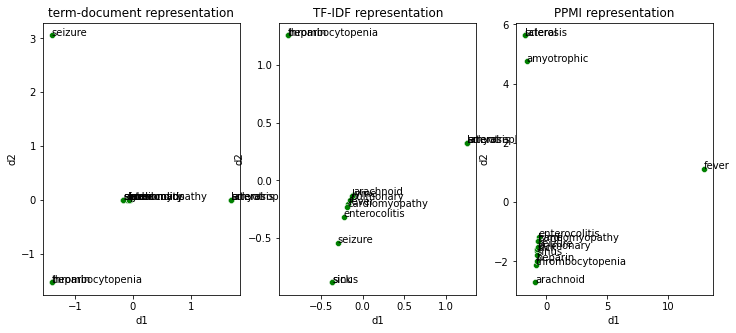

In [56]:
def vis(data, title, ax):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    transformed = pd.DataFrame(pca_result, columns=['d1', 'd2'])
    sns.scatterplot(x="d1",
                    y="d2",
                    data=transformed,
                    legend="full",
                    color='g',
                    ax=ax)
    for i in range(transformed.shape[0]):
        ax.text(x=transformed.d1[i], y=transformed.d2[i], s=data.index[i])
    ax.set_title(title)
given_terms = [
    'sick', 'sinus', 'thrombocytopenia', 'fever', 'heparin', 'cardiomyopathy',
    'amyotrophic', 'pulmonary', 'seizure', 'lateral', 'sclerosis', 'arachnoid',
    'enterocolitis', 'lyme'
]
# given_terms = [
#     'sick', 'sinus', 'thrombocytopenia', 'fever', 'heparin', 'cardiomyopathy',
#     'amyotrophic', 'pulmonary', 'seizure', 'lateral'
# ]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
vis(df_termdoc.loc[given_terms], 'term-document representation', ax1)
vis(df_tfidf.loc[given_terms], 'TF-IDF representation', ax2)
vis(ppmi_df.loc[given_terms], 'PPMI representation', ax3)

### Document classification<a class="anchor" id="5_3"></a>
- labels: use `gold mention-to-UMLS label` as the document class
- features: 
    - Term-Docuent matrix: use document vector (columns) as features
    - TF-IDF: use document vector (columns) as features
    - PPMI: use weighted (term frequency as the weight) average of all terms' context vectors (columns) as features.<br> 
    
Note: matrix multiplication can efficiently calculate the (weighted) sums.

In [58]:
def rf_classification(X, y, test_size=sizeoftest, random_state=seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    rfc = RandomForestClassifier(random_state=random_state)
    rfc.fit(X_train, y_train)

    # predictions
    rfc_predict = rfc.predict(X_test)
    return classification_report(y_test, rfc_predict)


def svm_classification(X, y, test_size=sizeoftest, random_state=seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    svc = SVC(random_state=random_state)
    svc.fit(X_train, y_train)

    # predictions
    svc_predict = svc.predict(X_test)
    return classification_report(y_test, svc_predict)

In [59]:
# classificaiton results    
labels = [0, 1]
y = [labels.index(df.loc[d, 'gold mention-to-UMLS label']) for d in df.index]

print('========== Term frequency represetation result (random forest) ==========')
print(rf_classification(df_termdoc.transpose(), y))
print('========== Term frequency represetation result (svm) ==========')
print(svm_classification(df_termdoc.transpose(), y))
print('==========     TF-IDF represetation result (random forest)    ==========')
print(rf_classification(df_tfidf.transpose(), y))
print('==========     TF-IDF represetation result (svm)    ==========')
print(svm_classification(df_tfidf.transpose(), y))
# print('==========     PPMI represetation result (random forest)    ==========')
# ppmi_df = ppmi_df.reindex(df_termdoc.index)
# print(rf_classification(df_termdoc.transpose().dot(ppmi_df), y))
# print('==========     PPMI represetation result (svm)    ==========')
# ppmi_df = ppmi_df.reindex(df_termdoc.index)
# print(svm_classification(df_termdoc.transpose().dot(ppmi_df), y))

========== Term frequency represetation result (random forest) ==========
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.97      0.94      0.96        68

    accuracy                           0.97       215
   macro avg       0.97      0.96      0.97       215
weighted avg       0.97      0.97      0.97       215

========== Term frequency represetation result (svm) ==========
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.97      0.94      0.96        68

    accuracy                           0.97       215
   macro avg       0.97      0.96      0.97       215
weighted avg       0.97      0.97      0.97       215

==========     TF-IDF represetation result (random forest)    ==========
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.97   